# Dependencies

In [1]:
from sys import path
path.append('src/')

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import pickle as pkl
from math import ceil
from sklearn.metrics import confusion_matrix, accuracy_score
from sklearn.preprocessing import LabelEncoder
from src.mrk_file import MRKFile
from src.iso_standard import PhotographicRequirements
from src.utils.plot import plot_confusion_matrix
from keras.applications import MobileNet
from keras.layers import GlobalAveragePooling2D, Dense
from keras.models import Model, Input

%matplotlib inline

Using TensorFlow backend.


In [2]:
FILE_TRAIN_DUMP = 'data/train_dump.pkl'
FILE_TRAIN_BOTTLENECKS = 'data/train_bottlenecks.pkl'

FILE_VAL_DUMP = 'data/val_dump.pkl'
FILE_VAL_BOTTLENECKS = 'data/val_bottlenecks.pkl'

INPUT_SHAPE = (224, 224, 3)

In [3]:
output_names = ['blurred', 
                'looking_away', 
                'ink_marked_creased', 
                'unnatural_skin_tone', 
                'too_dark_light', 
                'washed_out', 
                'pixelation', 
                'hair_across_eyes', 
                'eyes_closed', 
                'varied_background', 
                'roll_pitch_yaw', 
                'flash_reflection_on_skin', 
                'red_eyes', 
                'shadows_behind_head', 
                'shadows_across_face', 
                'dark_tinted_lenses', 
                'flash_reflection_on_lenses', 
                'frames_too_heavy', 
                'frame_covering_eyes', 
                'hat_cap', 
                'veil_over_face', 
                'mouth_open', 
                'presence_of_other_faces_or_toys']

# Helper Methods 

In [15]:
def history_to_dataframe(history, epoch=-1):
    loss_train = np.array([history[name + '_loss'][epoch] for name in output_names])
    loss_val = np.array([history['val_' + name + '_loss'][epoch] for name in output_names])
    acc_train = np.array([history[name + '_acc'][epoch] for name in output_names]) * 100
    acc_val = np.array([history['val_' + name + '_acc'][epoch] for name in output_names]) * 100

    data = np.concatenate(([loss_train], [loss_val], [acc_train], [acc_val]), axis=0).T
    return pd.DataFrame(data, columns=['loss_train', 'loss_val', 'acc_train', 'acc_val'], index=output_names)

def plot_history(history):
    n_graphs = len(output_names) * 2
    n_cols = 2
    n_rows = ceil(n_graphs / n_cols)

    plt.figure(figsize=(16, 100))
    for i, name in zip(range(1, n_graphs, 2), output_names):
        loss_train = history[name + '_loss']
        loss_val = history['val_' + name + '_loss']
        acc_train = history[name + '_acc']
        acc_val = history['val_' + name + '_acc']

        train_metrics = [loss_train, acc_train]
        val_metrics = [loss_val, acc_val]
        metrics = ['loss', 'acc']
        for sub, train, val, metric in zip([i, i + 1], train_metrics, val_metrics, metrics):
            plt.subplot(n_rows, n_cols, sub)
            plt.plot(train, label='train')
            plt.plot(val, label='val')
            plt.xlabel('epoch')
            plt.ylabel(metric)
            plt.title('{} ({})'.format(name, metric))
            plt.legend()
    plt.tight_layout()
    
def plot_heatmaps(y_trues, y_preds, figsize=(20, 20)):
    plt.figure(figsize=figsize)

    n_graphs = len(output_names)
    n_cols = 5
    n_rows = ceil(n_graphs / n_cols)
    labels = np.unique(y_trues)

    for i, name, y_true, y_pred in zip(range(1, n_graphs + 1), output_names, y_trues, y_preds):
        y_pred = np.argmax(y_pred, axis=-1)
        conf_matrix = confusion_matrix(y_true.ravel(), y_pred, labels=labels)

        plt.subplot(n_rows, n_cols, i)
        plot_confusion_matrix(conf_matrix, 
                              target_names=['D', 'NC', 'C'], 
                              title=name, 
                              normalize=True)
    plt.savefig('teste.pdf')

# Load Data 

In [5]:
train_image_files, x_train, train_mrks = pkl.load(open(FILE_TRAIN_DUMP, 'rb'))

print(len(train_image_files), type(train_image_files))
print(x_train.shape, x_train.dtype)
print(len(train_mrks), type(train_mrks[0]))

5211 <class 'list'>
(5211, 224, 224, 3) float32
5211 <class 'src.mrk_file.MRKFile'>


In [6]:
val_image_files, x_val, val_mrks = pkl.load(open(FILE_VAL_DUMP, 'rb'))

print(len(val_image_files), type(val_image_files))
print(x_val.shape, x_val.dtype)
print(len(val_mrks), type(val_mrks[0]))

565 <class 'list'>
(565, 224, 224, 3) float32
565 <class 'src.mrk_file.MRKFile'>


# Save Bottlenecks 

In [7]:
base_model = MobileNet(input_shape=INPUT_SHAPE, weights='imagenet', include_top=False)

In [8]:
train_features = base_model.predict(x_train, batch_size=32, verbose=1)
val_features = base_model.predict(x_val, batch_size=32, verbose=1)

print(train_features.shape, train_features.dtype)
print(val_features.shape, val_features.dtype)

565/565 [==============================] - 1s 1ms/step
(5211, 7, 7, 1024) float32
(565, 7, 7, 1024) float32


In [9]:
train_values = np.array([mrk.photo_reqs.values() for mrk in train_mrks], dtype=np.int8)
val_values = np.array([mrk.photo_reqs.values() for mrk in val_mrks], dtype=np.int8)

print(train_values.shape, train_values.dtype)
print(val_values.shape, val_values.dtype)

(5211, 23) int8
(565, 23) int8


In [10]:
pkl.dump((train_features, train_values), open(FILE_TRAIN_BOTTLENECKS, 'wb'), protocol=-1)
pkl.dump((val_features, val_values), open(FILE_VAL_BOTTLENECKS, 'wb'), protocol=-1)

# Transfer Learning 

In [5]:
train_features, train_values = pkl.load(open(FILE_TRAIN_BOTTLENECKS, 'rb'))
val_features, val_values = pkl.load(open(FILE_VAL_BOTTLENECKS, 'rb'))

print(train_features.shape, train_features.dtype)
print(train_values.shape, train_values.dtype)
print(val_features.shape, val_features.dtype)
print(val_values.shape, val_values.dtype)

(5211, 7, 7, 1024) float32
(5211, 23) int8
(565, 7, 7, 1024) float32
(565, 23) int8


In [6]:
# encode reqs values from [-1, 0, 1] => [0, 1, 2]
enc = LabelEncoder()
enc.fit(train_values.ravel())

y_train = enc.transform(train_values.ravel()).reshape(train_values.shape)
y_val = enc.transform(val_values.ravel()).reshape(val_values.shape)

assert(y_train.shape == train_values.shape)
assert(y_val.shape == val_values.shape)
assert(np.all(y_train == train_values + 1))
assert(np.all(y_val == val_values + 1))

In [7]:
inputs = Input(shape=train_features.shape[1:], name='inputs')
avg_pool = GlobalAveragePooling2D()(inputs)

r2 = Dense(units=3, activation='softmax', name=output_names[0])(avg_pool)
r3 = Dense(units=3, activation='softmax', name=output_names[1])(avg_pool)
r4 = Dense(units=3, activation='softmax', name=output_names[2])(avg_pool)
r5 = Dense(units=3, activation='softmax', name=output_names[3])(avg_pool)
r6 = Dense(units=3, activation='softmax', name=output_names[4])(avg_pool)
r7 = Dense(units=3, activation='softmax', name=output_names[5])(avg_pool)
r8 = Dense(units=3, activation='softmax', name=output_names[6])(avg_pool)
r9 = Dense(units=3, activation='softmax', name=output_names[7])(avg_pool)
r10 = Dense(units=3, activation='softmax', name=output_names[8])(avg_pool)
r11 = Dense(units=3, activation='softmax', name=output_names[9])(avg_pool)
r12 = Dense(units=3, activation='softmax', name=output_names[10])(avg_pool)
r13 = Dense(units=3, activation='softmax', name=output_names[11])(avg_pool)
r14 = Dense(units=3, activation='softmax', name=output_names[12])(avg_pool)
r15 = Dense(units=3, activation='softmax', name=output_names[13])(avg_pool)
r16 = Dense(units=3, activation='softmax', name=output_names[14])(avg_pool)
r17 = Dense(units=3, activation='softmax', name=output_names[15])(avg_pool)
r18 = Dense(units=3, activation='softmax', name=output_names[16])(avg_pool)
r19 = Dense(units=3, activation='softmax', name=output_names[17])(avg_pool)
r20 = Dense(units=3, activation='softmax', name=output_names[18])(avg_pool)
r21 = Dense(units=3, activation='softmax', name=output_names[19])(avg_pool)
r22 = Dense(units=3, activation='softmax', name=output_names[20])(avg_pool)
r23 = Dense(units=3, activation='softmax', name=output_names[21])(avg_pool)
r24 = Dense(units=3, activation='softmax', name=output_names[22])(avg_pool)

model = Model(inputs=inputs, 
              outputs=[r2, r3, r4, r5, r6, r7, r8, r9, r10, r11, r12, r13, r14, r15, r16, r17, r18, r19, r20, r21, r22, r23, r24], 
              name='icaonet')

model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
inputs (InputLayer)             (None, 7, 7, 1024)   0                                            
__________________________________________________________________________________________________
global_average_pooling2d_1 (Glo (None, 1024)         0           inputs[0][0]                     
__________________________________________________________________________________________________
blurred (Dense)                 (None, 3)            3075        global_average_pooling2d_1[0][0] 
__________________________________________________________________________________________________
looking_away (Dense)            (None, 3)            3075        global_average_pooling2d_1[0][0] 
__________________________________________________________________________________________________
ink_marked

In [8]:
hist = model.fit(train_features, 
                 np.hsplit(y_train, range(1, y_train.shape[1])), 
                 batch_size=32, 
                 epochs=1, 
                 validation_data=(val_features, np.hsplit(y_val, range(1, y_val.shape[1]))))

# plot_history(hist.history)
history_to_dataframe(hist.history, epoch=0)

Train on 5211 samples, validate on 565 samples
Epoch 1/1
5211/5211 [==============================] - 7s 1ms/step - loss: 8.9686 - blurred_loss: 0.4708 - looking_away_loss: 0.7572 - ink_marked_creased_loss: 0.2354 - unnatural_skin_tone_loss: 0.2193 - too_dark_light_loss: 0.2455 - washed_out_loss: 0.0242 - pixelation_loss: 0.2756 - hair_across_eyes_loss: 0.3254 - eyes_closed_loss: 0.5723 - varied_background_loss: 0.3278 - roll_pitch_yaw_loss: 0.6519 - flash_reflection_on_skin_loss: 0.4268 - red_eyes_loss: 0.5120 - shadows_behind_head_loss: 0.6165 - shadows_across_face_loss: 0.4012 - dark_tinted_lenses_loss: 0.3198 - flash_reflection_on_lenses_loss: 0.3978 - frames_too_heavy_loss: 0.3376 - frame_covering_eyes_loss: 0.6127 - hat_cap_loss: 0.3857 - veil_over_face_loss: 0.1704 - mouth_open_loss: 0.6161 - presence_of_other_faces_or_toys_loss: 0.0662 - blurred_acc: 0.8455 - looking_away_acc: 0.6908 - ink_marked_creased_acc: 0.9321 - unnatural_skin_tone_acc: 0.9363 - too_dark_light_acc: 0.9382

,loss_train,loss_val,acc_train,acc_val
blurred,0.470837,0.374679,84.551909,85.309735
looking_away,0.757192,0.706299,69.084629,78.407080
ink_marked_creased,0.235437,0.037881,93.206678,99.823009
unnatural_skin_tone,0.219281,1.396431,93.628862,70.796460
too_dark_light,0.245531,0.544192,93.820764,87.964602
washed_out,0.024184,0.648495,99.347534,93.982301
pixelation,0.275642,0.255110,92.458261,94.690266
hair_across_eyes,0.325441,0.574361,88.140472,91.504425
eyes_closed,0.572347,0.549593,80.617924,85.132743
varied_background,0.327832,1.090294,87.046632,76.106195


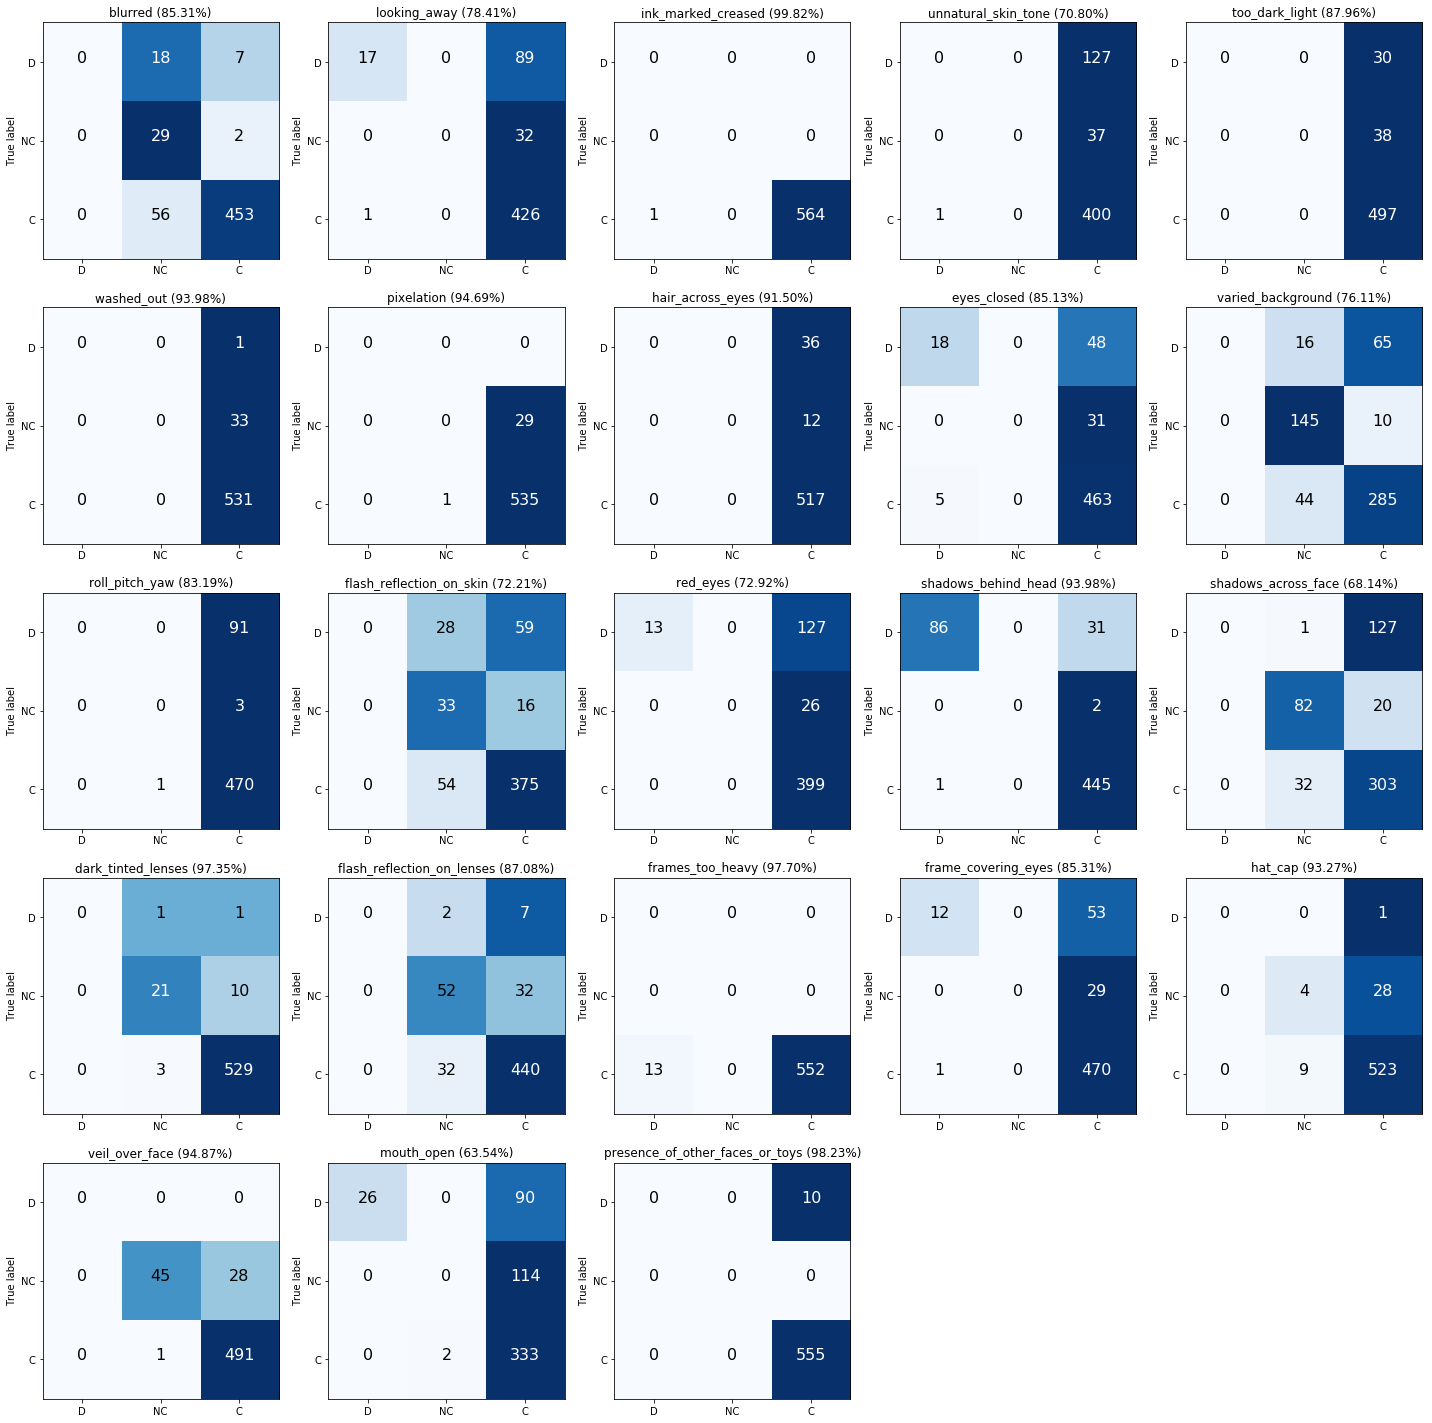

In [18]:
y_trues = np.hsplit(y_val, range(1, y_val.shape[1]))
y_preds = model.predict(val_features)

plot_heatmaps(y_trues, y_preds)